In [1]:
#import
import pandas as pd
from pathlib import Path
import json
import numpy as np
import os

## Read in respiratory trace
* Data must be formatted in bids
    * Resp file must be "tsv" or "tsv.gz"
    * json metadata file must be present
    * json metadata file must have the attribute "Column" which is a list of labels corresponding to the columns in the data file
    * respiratory label must be named "respiratory"
    * alternatively, pass in the column number that the respiratory trace corresponds to (INDEX STARTS AT 0)

In [2]:
#export
def read_respiratory_trace(bids_physio_file, column=None):
    # Read in physio file and extract only the physio data
    if column is None:
        if "tsv.gz" in bids_physio_file:
            physio_json = bids_physio_file.replace("tsv.gz", "json")
        elif "tsv" in bids_physio_file:
            physio_json = bids_physio_file.replace("tsv", "json")
        else:
            raise ValueError("the physio file must be a tsv or tsv.gz file")
        #read physio json
        with open(physio_json) as f:
            metadata = json.load(f)       
        #get respiratory index
        resp_index = metadata["Columns"].index("respiratory")
    else:
        # just set index as column value
        resp_index = int(column)
    #read physio data 
    physio_data = np.genfromtxt(bids_physio_file)
    #return column of respiratory trace
    return physio_data[:, resp_index]

## Extract Max Frequency
* get the top frequency in the respiratory trace
* should look over this code to make sure it's correct
* using a modified version of this code: https://www.kite.com/python/answers/how-to-plot-a-power-spectrum-in-python

In [3]:
import matplotlib.pyplot as plt

In [4]:
#export
def extract_max_freq(resp_trace, sampling_rate):
    fourier_transform = np.fft.rfft(resp_trace)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))
    assert len(power_spectrum) == len(frequency)
    plt.plot(frequency, power_spectrum)
    plt.xlim(0, 1)
    plt.show()
    return frequency[np.argmax(power_spectrum)]

## Filter Frequency
* Look over this script
* taken from here: https://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter

In [5]:
#import 
from scipy.signal import butter, lfilter

In [6]:
#export 
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filter_frequency(data):
    return butter_bandpass_filter(data, 0.05, 1, 62.5)

## Write output to file
* make sure the directory exists

In [7]:
#export
def write_output(output_folder, physio_path, data):
    out = Path(output_folder)
    if not out.is_dir():
        raise FileNotFoundError("output directory is not found")
    outname = "{}.1D".format(os.path.basename(physio_path).split(".")[0])
    np.savetxt(str(out/outname), data, fmt="%.06f")
    return str(out/outname)

In [8]:

physio_path = "../../data/sub-A00051456_ses-DS2_task-rest_acq-1400_physio.tsv.gz"
output_dir = "../../data"

In [9]:
#export

def process_physio(physio_path, output_dir):
    rt = read_respiratory_trace(physio_path)
    #demean rt
    rt = rt-np.mean(rt)
    max_freq = extract_max_freq(rt, 62.5)
    if (max_freq>0.15) and (max_freq<1):
        filtered = filter_frequency(rt)
        #extract_max_freq(filtered, 62.5)
        return write_output(output_dir, physio_path, filtered)
    else:
        return None


## Make Retroicor String
* Make the bash command for 3dretroicor
* Only respiratory data

In [10]:
#export
def make_retroicor_string(nifti_image, physio_path, output_dir):
    new_nifti_name = "{}_retroicor.nii.gz".format(os.path.basename(nifti_image).split(".")[0])
    output_dir = Path(output_dir).resolve()
    return "3dretroicor -prefix {} -resp {} {}" .format(output_dir/new_nifti_name, physio_path, nifti_image)

In [11]:
#import 
import time
from subprocess import Popen, PIPE
import shlex

In [12]:
#export
def print_cmd(cmd_str):
    print(cmd_str.replace(" -", "\n -"))


def run_cmd(cmd):
    start_time = time.time()
    print_cmd(cmd)
    p = Popen(shlex.split(cmd), stdout=PIPE, stderr=PIPE)
    stdout, stderr = p.communicate()
    print("Elapsed time: {:.2f}s".format(time.time() - start_time))

In [13]:
#fire 
def run(nifti_image, physio_path, output_dir):
    processed_physio_path = process_physio(physio_path, output_dir)
    if processed_physio_path is None:
        print("{}: bad physio file".format(physio_path))
        return 
    #resolve full physio_path
    processed_physio_path = Path(processed_physio_path).resolve()
    retroicor_str = make_retroicor_string(nifti_image, processed_physio_path, output_dir)
    print(retroicor_str)
    run_cmd(retroicor_str)

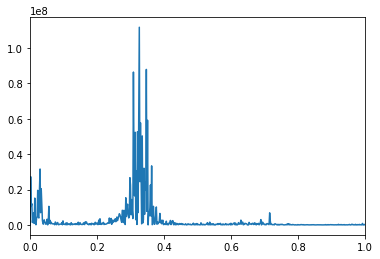

3dretroicor -prefix /home/cbin-user/proj/run_retroicor/data/sub-A00037582_ses-DS2_task-rest_acq-1400_bold_retroicor.nii.gz -resp /home/cbin-user/proj/run_retroicor/data/sub-A00037582_ses-DS2_task-rest_acq-1400_physio.1D ../../data/sub-A00037582/sub-A00037582_ses-DS2_task-rest_acq-1400_bold.nii.gz
3dretroicor
 -prefix /home/cbin-user/proj/run_retroicor/data/sub-A00037582_ses-DS2_task-rest_acq-1400_bold_retroicor.nii.gz
 -resp /home/cbin-user/proj/run_retroicor/data/sub-A00037582_ses-DS2_task-rest_acq-1400_physio.1D ../../data/sub-A00037582/sub-A00037582_ses-DS2_task-rest_acq-1400_bold.nii.gz
Elapsed time: 259.02s


In [14]:
run("../../data/sub-A00037582/sub-A00037582_ses-DS2_task-rest_acq-1400_bold.nii.gz", 
    "../../data/sub-A00037582/sub-A00037582_ses-DS2_task-rest_acq-1400_physio.tsv.gz", 
   "../../data")